In [55]:
import talib
import random
import datetime
import itertools
import pyfolio as pf
import numpy as np 
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
from tqdm import tqdm_notebook
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, optimizers
%matplotlib inline

# Data

In [56]:
start = datetime.datetime(2010, 2, 20)
end = datetime.datetime(2020, 12, 1)

In [57]:
stock = pdr.get_data_yahoo('SCB.BK', start=start, end=end)

In [58]:
adx = talib.ADX(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
cci = talib.CCI(stock['High'], stock['Low'], stock['Close'], timeperiod=14)
rsi = talib.RSI(stock['Close'], timeperiod=14)
stock['ADX'] = adx
stock['CCI'] = cci
stock['RSI'] = rsi

In [59]:
data = stock[['Adj Close', 'ADX', 'CCI', 'RSI']].dropna()

In [60]:
split = int(len(data)*0.7)+1
train_data = data[:split]
test_data = data[split:]

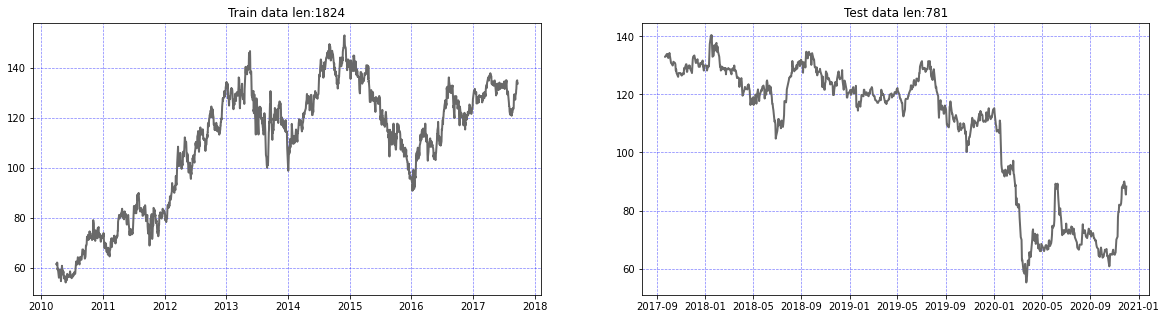

In [61]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

columns = 'Adj Close'
ax1.plot(train_data[columns], color='dimgray',lw=2)
ax1.title.set_text('Train data len:'+str(len(train_data)), )
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

ax2.plot(test_data[columns], color='dimgray',lw=2)
ax2.title.set_text('Test data len:'+str(len(test_data)))

ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

# Class Neural Network

In [62]:
class DenseNetwork(models.Model):
    
    def __init__(self,input_sz, output_sz, hidden_sz):
        super(DenseNetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(input_sz,))
        self.hidden_layer = [layers.Dense(i, activation='relu') for i in hidden_sz]
        self.output_layer = layers.Dense(output_sz, activation = 'linear')
        
    def call(self, x):
        x = self.input_layer(x)
        for l in self.hidden_layer:
            x = l(x)
        return self.output_layer(x)

# Env

In [63]:
class GridTradingEnv(): 
    def __init__(self, 
                 data=None, 
                 initial_capital=100000,
                 zone_grid=[0,20],
                 min_limit=100,
                 transaction_cost=0):
        
        self.stock_price_history = data.iloc[:,0]
        self.indicator_history1 = data.iloc[:,1]
        self.indicator_history2 = data.iloc[:,2]
        self.indicator_history3 = data.iloc[:,3]
        self.n_step = self.stock_price_history.shape[0] # n stock
        self.n_stock = 1
        
        self.initial_capital = initial_capital
        self.lower_zone = zone_grid[0]
        self.upper_zone = zone_grid[1]
        self.min_limit = min_limit
        #self.max_pos = 2*self.initial_capital/(self.upper_zone-self.lower_zone)
        self.max_pos = self.initial_capital/((self.upper_zone+self.lower_zone)/2)
        
        self.begin_portfolio_value = initial_capital
        self.transaction_cost = transaction_cost
        
        self.n_buy = None
        self.n_sell = None
        self.marker = None
        self.memory = None
        
        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.indicator1 = None
        self.indicator2 = None
        self.indicator3 = None
        self.cash = None
        
        self.action_list = list(map(list, itertools.product(np.arange(3), repeat=self.n_stock))) 
        self.action_space = np.arange(len(self.action_list)**self.n_stock) 
        self.state_space = 4*self.n_stock
        
        self.reset()
        
    def __str__(self):
        return "Env(Len_data:%s, Capital:%s, Lower_zone:%s, Upper_zone:%s, Max_pos:%.2f, Min_limit:%s)" %(self.n_step,
                                                                                                        self.initial_capital, 
                                                                                                        self.lower_zone, 
                                                                                                        self.upper_zone,
                                                                                                        self.max_pos,
                                                                                                        self.min_limit)
    def strategy_plot(self, plus):
        x1 = np.arange(self.lower_zone-plus, self.upper_zone+plus+1)
        x2 = np.arange(0, self.upper_zone+2)
        y_linear = []
        y_port_val = []
        
        for i in x1:
            y_linear.append(self.linear_func(i))
        for i in x2:
            y_port_val.append(self.port_val_func(i))
            
        fig = plt.figure(figsize=(15,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        ax1.plot(x1, y_linear)
        ax1.title.set_text('Linear Function')
        ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)
        ax1.set_ylabel('Position')
        ax1.set_xlabel('Price')
        
        ax2.plot(x2, y_port_val)
        ax2.title.set_text('Portfolio Value Curve')
        ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)
        ax2.set_ylabel('Port Value')
        ax2.set_xlabel('Price')
        
        plt.show()
                                                                                  
    def reset(self):
        self.marker = []
        self.memory = []
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self, action):
        assert action in self.action_space
        prev_val = self.port_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.indicator1 = self.indicator_history1[self.cur_step]
        self.indicator2 = self.indicator_history2[self.cur_step]
        self.indicator3 = self.indicator_history3[self.cur_step]
        
        self._trade(action)
        
        cur_val = self.port_val()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - 1
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.stock_price
        obs[1] = self.indicator1
        obs[2] = self.indicator2
        obs[3] = self.indicator3
        return obs
      
    def port_val(self):
        return self.position*self.stock_price + self.cash 
    
    def port_val_func(self, price):
        price = np.min([self.upper_zone, price])
        rect = np.min([self.lower_zone, price])
        y1 = self.linear_func(price)
        port_val = 0.5*(self.max_pos+y1)*(price-rect)+self.max_pos*rect
        return port_val
    
    def linear_func(self, price): 
        x1 = np.max([self.lower_zone, price])
        x2 = np.min([self.upper_zone, x1])
        m = self.max_pos/(self.lower_zone-self.upper_zone)
        y = m*x2 - self.upper_zone*m 
        return y
        
    def _trade(self,action):  
        #sell=0, hold=1, buy=2
        adjust_pos = self.linear_func(self.stock_price)
        diff = adjust_pos-self.position
        
        #sell
        if action==0 and diff<=-self.min_limit and self.position>=abs(diff): 
            self.position -= abs(diff)
            self.cash += self.stock_price*abs(diff)
            self.n_sell += 1
            self.marker.append(0)
        #buy
        elif action==2 and diff>=self.min_limit and self.cash>=self.stock_price*abs(diff): 
            self.position += abs(diff)
            self.cash -= self.stock_price*abs(diff)
            self.n_buy += 1
            self.marker.append(2)
        #hold
        else:
            self.marker.append(1) 
    
    def check_result(self):
        df = pd.DataFrame(self.memory, columns=['Price', 'Adj Position', 'Position', 'Cash', 'Equity Curve', 'Action'])
        return df
    
    def save_result(self, price, adj_pos, pos, cash, equity, act):
        self.memory.append((price, adj_pos, pos, cash, equity, act))
       

# Backtest DDQN

In [82]:
backtest_data = test_data

env = GridTradingEnv(backtest_data, initial_capital=500000, zone_grid=[60,120], min_limit=100)

#Set weight neural network
backtest_model = DenseNetwork(env.state_space, len(env.action_space), [256,256,256,256,256])
backtest_model.build((None, env.state_space))
backtest_model.load_weights('test_SCB.h5')

========Backtesting Performance========
begin_portfolio_value: 500000.00
end_portfolio_value: 555189.72
total_profit: 55189.72
%profit: 11.04 %
buy: 36, sell: 18


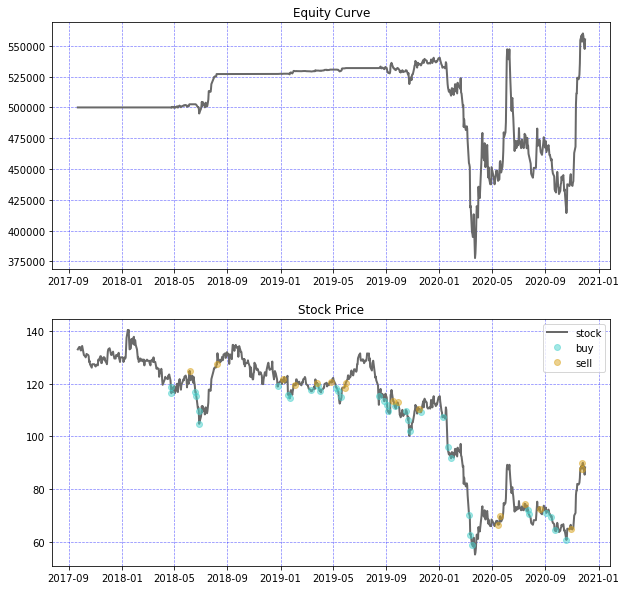

In [83]:
states = []
for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
        break
scaler = StandardScaler()
scaler.fit(states)

state = env.reset()
state = scaler.transform([state])
    
equity_curve = np.empty([env.n_step-1])
total_reward = np.zeros(1)
i = 0
    
while True:

    action = np.argmax(backtest_model.call(state)[0])
    equity_curve[i] =  env.port_val()

    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    
    env.save_result(env.stock_price.item(), 
                         env.linear_func(env.stock_price).item(),
                         env.position.item(),
                         np.array(env.cash).item(),
                         env.port_val().item(),
                         action)

    total_reward += reward
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
        print(f'end_portfolio_value: {env.port_val()[0]:.2f}')
        print(f'total_profit: {total_reward[0]:.2f}')
        print(f'%profit: {total_reward[0]/env.begin_portfolio_value*100:.2f} %')
        print(f'buy: {env.n_buy}, sell: {env.n_sell}')
        print("=======================================")

        break

def result4plot(data, action, port_val):
    data = data.drop(data.index[0])
    data['Action'] = np.array(action)
    data['Equity Curve'] = np.array(port_val)
    marker = data.drop(data.columns[[1, 2, 3]], axis=1)
    eqtc = data.drop(data.columns[[0, 1, 2, 3, 4]], axis=1)
    return marker, eqtc, data

#Set marker buy&sell
marker, eqtc, bt_data = result4plot(backtest_data, env.marker, env.check_result()['Equity Curve'])
marker_buy = marker[marker['Action']==2].iloc[:,0]
marker_sell = marker[marker['Action']==0].iloc[:,0]

#Plot Visualization
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(eqtc, color='dimgray',lw=2)
ax1.title.set_text('Equity Curve')
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

ax2.plot(bt_data.iloc[:,0], color='dimgray',lw=2)
ax2.plot(marker_buy, 'o', color='mediumturquoise', lw=0.1, alpha=0.5)
ax2.plot(marker_sell, 'o', color='goldenrod', lw=0.1, alpha=0.5)
ax2.title.set_text('Stock Price')
ax2.legend(['stock','buy','sell'])
ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.7)

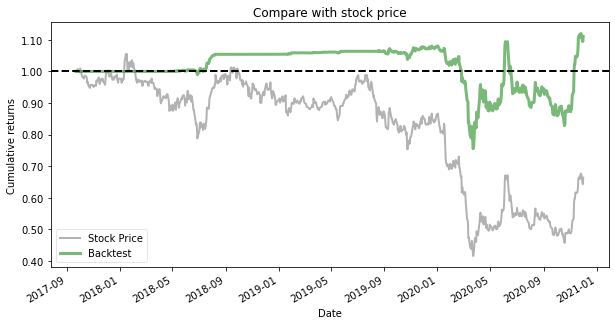

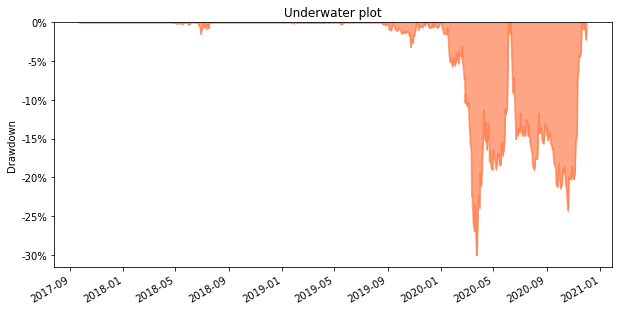

In [84]:
#PLot compare with benchmark
plt.figure(figsize=(10,5));
eqtc = eqtc.rename(columns = {'Equity Curve': 'DDQN'}).squeeze()
bt_data = bt_data.rename(columns = {'Adj Close': 'Stock Price'})

pf.plotting.plot_rolling_returns(eqtc.pct_change(), bt_data.iloc[:,0].pct_change());
plt.title('Compare with stock price');

plt.figure(figsize=(10,5));
pf.plot_drawdown_underwater(eqtc.pct_change());

# Backtest momentum trading

In [119]:
def momentumSignal(state):
    if state[3]>=65:
        return 0
    elif state[3]<=25:
        return 2
    else:
        return 1  

In [120]:
state = env.reset()
    
total_reward = np.zeros(1)
i = 0
    
while True:
    
    action = momentumSignal(state)
    next_state, reward, done, info = env.step(action)
    
    env.save_result(env.stock_price.item(), 
                         env.linear_func(env.stock_price).item(),
                         env.position.item(),
                         np.array(env.cash).item(),
                         env.port_val().item(),
                         action)


    total_reward += reward
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {env.begin_portfolio_value:.2f}')
        print(f'end_portfolio_value: {env.port_val()[0]:.2f}')
        print(f'total_profit: {total_reward[0]:.2f}')
        print(f'%profit: {total_reward[0]/env.begin_portfolio_value*100:.2f} %')
        print(f'buy: {env.n_buy}, sell: {env.n_sell}')
        print("=======================================")

        break

def result4plot(data, action, port_val):
    data = data.drop(data.index[0])
    data['Action'] = np.array(action)
    data['Equity Curve'] = np.array(port_val)
    marker = data.drop(data.columns[[1, 2, 3]], axis=1)
    eqtc = data.drop(data.columns[[0, 1, 2, 3, 4]], axis=1)
    return marker, eqtc, data

#Set marker buy&sell
marker_f1, eqtc_f1, bt_data_f1 = result4plot(backtest_data, env.marker, env.check_result()['Equity Curve'])
marker_buy = marker_f1[marker_f1['Action']==2].iloc[:,0]
marker_sell = marker_f1[marker_f1['Action']==0].iloc[:,0]

========Backtesting Performance========
begin_portfolio_value: 500000.00
end_portfolio_value: 565937.25
total_profit: 65937.25
%profit: 13.19 %
buy: 8, sell: 4


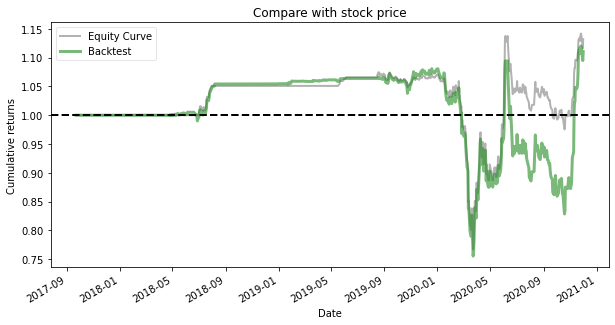

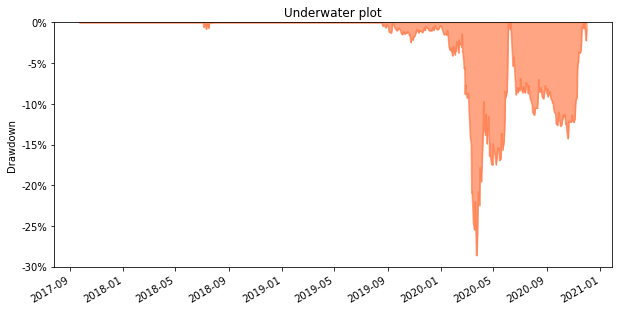

In [122]:
#PLot compare with benchmark
plt.figure(figsize=(10,5));
#eqtc = eqtc.rename(columns = {'Equity Curve': 'DDQN'}).squeeze()
eqtc = eqtc.squeeze()
eqtc_f1 = eqtc_f1.squeeze()
bt_data = bt_data.rename(columns = {'Adj Close': 'Stock Price'})

pf.plotting.plot_rolling_returns(eqtc.pct_change(), eqtc_f1.pct_change());
plt.title('Compare with stock price');

plt.figure(figsize=(10,5));
pf.plot_drawdown_underwater(eqtc_f1.pct_change());